In [18]:
import os, sys, json
sys.path.append('..')
import numpy as np
import torch as ch
import pandas as pd
import resource
from tqdm.notebook import tqdm
from robustness.model_utils import make_and_restore_model
from robustness.tools.vis_tools import show_image_row
from robustness import datasets
from robustness.tools.label_maps import CLASS_DICT
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
from objectnet_utils import load_ObjectNet, map_ImageNetToObjectNet, OBJN_TO_IN_MAP, LABEL_TO_IND

sns.set_style('darkgrid')

In [2]:
DATA_DIR = '/scratch/datasets/sandbox/objectnet-1.0' 
dataset, test_loader, label_map = load_ObjectNet(DATA_DIR, workers=5) #from objectnet class no -> folder name
label_map_r = {v: k for k, v in label_map.items()}

==> Preparing dataset imagenet..


In [ ]:
_, (im, targ) = next(enumerate(test_loader))

In [ ]:
show_image_row([im[:10]], tlist=[[label_map[int(t)] for t in targ]],
               fontsize=20)

In [ ]:
with open(os.path.join('../quality_control', 'label_map.json')) as f:
    corrected_mapping = json.load(f) # Chungus name -> folder name

In [ ]:
#corrected_mapping

In [ ]:
with open(os.path.join(DATA_DIR, 'mappings', 'folder_to_objectnet_label.json')) as f:
    folder_to_label = json.load(f) # folder name -> name
    
with open(os.path.join(DATA_DIR, 'mappings', 'imagenet_1k_indices_to_objectnet.json')) as f:
    in_to_obj_orig = json.load(f) # str imagenet class number -> name

In [ ]:
#folder_to_label, in_to_obj_orig

In [ ]:
label_map_r['drying_rack_for_dishes']

In [ ]:
obj_to_in = {} # ImageNet class no -> Objectnet class
for k, v in in_to_obj_orig.items():
    if ')(' in v: 
        vv = v.split(')(')[0] + ")"
    else:
        vv = v.split("(")[0]
    # vv: Name for class
    # Now map name -> folder_name
    km = [kf for kf, vf in folder_to_label.items() if vv == vf][0]
    km = label_map_r[km] #Map folder name back to objectnet class
    if km not in obj_to_in: 
        obj_to_in[km] = []
    obj_to_in[km].append(int(k))

In [11]:
obj_to_in

{1: [409, 530],
 2: [414],
 4: [954],
 5: [419],
 8: [790],
 108: [434],
 12: [440],
 15: [703],
 16: [671, 444],
 19: [446],
 28: [455],
 34: [930],
 37: [462],
 38: [463],
 39: [499],
 43: [473],
 44: [470],
 47: [487],
 51: [423, 559, 765],
 56: [588],
 60: [550],
 66: [507],
 67: [673],
 73: [846],
 116: [533],
 78: [539],
 83: [630],
 85: [740],
 86: [968],
 89: [729],
 96: [549],
 100: [545],
 107: [567],
 80: [578],
 111: [589],
 114: [587],
 120: [560, 518],
 124: [606],
 128: [608],
 131: [508],
 132: [618],
 133: [619],
 135: [620],
 138: [951],
 139: [623],
 142: [626],
 143: [629],
 149: [644],
 150: [647],
 151: [651],
 153: [659],
 154: [664],
 157: [504],
 160: [677],
 164: [679],
 171: [950],
 173: [695],
 175: [696],
 179: [700],
 182: [418, 749, 563],
 188: [720],
 190: [721],
 191: [725],
 193: [728],
 196: [923],
 199: [731],
 200: [737],
 201: [811],
 205: [742],
 210: [761],
 216: [769],
 217: [770],
 218: [772],
 219: [773],
 220: [774],
 223: [783],
 229: [792],

In [12]:
label_to_ind = {}

for k, v in corrected_mapping.items():
    #print(k, v)
    km = [kf for kf, vf in label_map.items() if v == vf][0]
    if km == 88:
        print(k, v)
        break
    label_to_ind[k] = km
    #break

In [13]:
for k, v in label_to_ind.items():
    if v not in obj_to_in:
        print(v, k)

## Get model

In [3]:
IN_DIR = '/scratch/engstrom_scratch/imagenet'

In [13]:
m, _ = make_and_restore_model(arch='resnet50', 
                                          dataset=datasets.ImageNet(IN_DIR),
                                          pytorch_pretrained=True)
m.eval()
m = ch.nn.DataParallel(m.cuda())

In [14]:
def get_preds(model, loader, map_dict, mode='restrict'):
    total = [0, 0]
    in_classes = [] 
    for v in map_dict.values():
        in_classes.extend(v)
    in_classes = list(set(in_classes))
    res = {'labs': [], 'preds': []}
    with ch.no_grad():
        for _, (im, targ) in enumerate(loader):
            op, _ = model(im)
            if mode != 'restrict':
                pred = ch.argmax(op, dim=1).cpu()
            else:
                # ch.gather
                op = op[:, in_classes]
                pred = ch.argmax(op, dim=1).cpu()
                pred = ch.tensor([in_classes[int(p)] for p in pred])
                
            corr = []
            for p, l in zip(pred, targ):
                if int(l) not in map_dict: continue
                corr.append(int(p) in map_dict[int(l)])
                res['labs'].append(str(map_dict[int(l)]))
                res['preds'].append(int(p))
            total[0] += sum(corr)
            total[1] += len(corr)
    return total, res

In [15]:
acc, res = get_preds(m, test_loader, OBJN_TO_IN_MAP)

In [16]:
acc[0] / acc[1]

0.362980510390869

In [38]:
df = pd.DataFrame(res)
df['uids'] = np.arange(len(df))

In [39]:
df = df.groupby(['labs', 'preds']).agg(num=('uids', 'count')).reset_index()
df['labs_int'] = df.labs.apply(lambda x: [int(xx) for xx in x[1:-1].split(',')])
df['sameclass'] = df.apply(lambda r: r['preds'] in r['labs_int'], axis=1)

In [42]:
perclass_acc_df = df.groupby(['sameclass', 'labs']).agg({'num': 'sum'}).reset_index()
perclass_acc_df = perclass_acc_df.pivot_table(index=['labs'], 
                                              columns='sameclass', values='num',
                                              fill_value=0).reset_index()
perclass_acc_df['acc'] = perclass_acc_df[True] / (perclass_acc_df[True] + perclass_acc_df[False])
perclass_acc_df['count'] = (perclass_acc_df[True] + perclass_acc_df[False])
perclass_acc_df

sameclass,labs,False,True,acc,count
0,"[409, 530]",115,29,0.201389,144
1,[412],211,31,0.128099,242
2,[414],100,135,0.574468,235
3,"[418, 749, 563]",73,116,0.613757,189
4,[419],104,140,0.573770,244
...,...,...,...,...,...
108,[950],57,86,0.601399,143
109,[951],45,103,0.695946,148
110,[954],55,180,0.765957,235
111,[968],155,4,0.025157,159


In [43]:
np.sum(perclass_acc_df['acc'] * perclass_acc_df['count']) / np.sum(perclass_acc_df['count'])

0.362980510390869

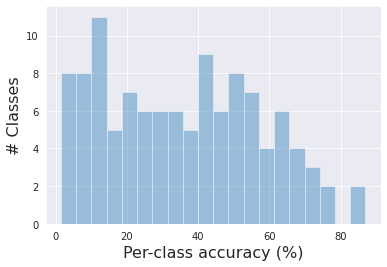

In [44]:
sns.distplot(100 * perclass_acc_df['acc'], kde=False, bins=20)
plt.xlabel('Per-class accuracy (%)', fontsize=16)
plt.ylabel('# Classes', fontsize=16)
plt.show()

## Load synthetic data

In [19]:
from pathlib import Path
from torchvision import transforms
from utils import RGBAToRGB, ModelDataset, details_df
from colorsys import hsv_to_rgb, rgb_to_hsv
from make_predictions import make_predictions

In [20]:
DS_PATH = '/scratch/datasets/sandbox/v0'
ds_path = Path(DS_PATH)
root_df = details_df(ds_path)
ds = datasets.ImageNet((ds_path, root_df))

In [34]:
ds.custom_class = ModelDataset
ds.custom_class_args = {
    'subset': 10000
}
ds.transform_test = transforms.Compose([
            RGBAToRGB(hsv_to_rgb(1, 1, 1)),
            #transforms.CenterCrop((40, 40)),
            transforms.CenterCrop(224),
            transforms.ToTensor()
        ])

In [1]:
_, loader = ds.make_loaders(workers=10, 
                            batch_size=10, 
                            only_val=True)

NameError: name 'ds' is not defined

In [46]:
OBJ_TO_IN

NameError: name 'OBJ_TO_IN' is not defined

In [36]:
_, res = next(enumerate(loader))
im, targ = res[0], res[1]

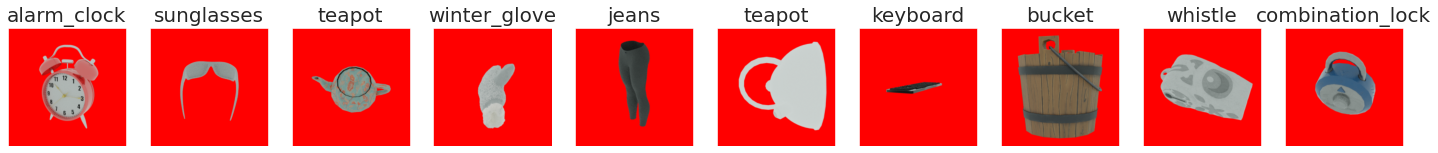

In [37]:
show_image_row([im[:10]], tlist=[[label_map[int(t)] for t in targ]],
               fontsize=20)

In [39]:
acc_df = make_predictions(m, ds, OBJN_TO_IN_MAP, 
                          mode='restrict',
                         workers=4, batch_size=100)

  0%|          | 0/100 [00:00<?, ?it/s]

==> Preparing dataset imagenet..


100%|██████████| 100/100 [00:14<00:00,  6.70it/s]


In [40]:
acc_df['corr'] = acc_df.apply(lambda r: r['preds'] in r['labs'], axis=1)

In [41]:
100 * np.mean(acc_df['corr'])

20.979999999999997

In [20]:
from sklearn.metrics import confusion_matrix

In [21]:
CM = confusion_matrix(acc_df['labs'], acc_df['preds'], normalize='true')

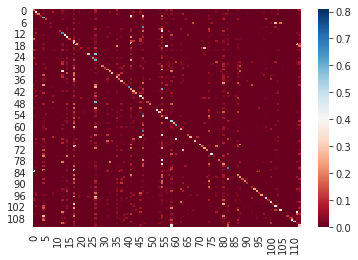

In [22]:
sns.heatmap(CM, cmap='RdBu')
plt.show()

/opt/miniconda/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


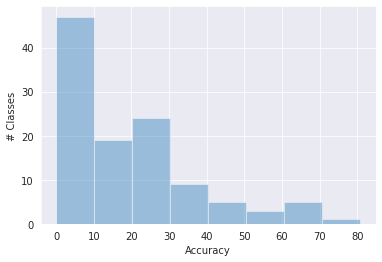

In [23]:
sns.distplot(100 * np.diag(CM), kde=False)
plt.xlabel('Accuracy')
plt.ylabel('# Classes')
plt.show()

In [24]:
idx = np.argsort(np.diag(CM))[::-1]

print([(label_map[l], f"{100 * np.diag(CM)[l]:.2f}") for l in idx[:10]])

[('board_game', '80.82'), ('dress_shirt', '66.73'), ('beer_bottle', '64.82'), ('butter', '64.67'), ('coffee_french_press', '63.21'), ('bookend', '60.66'), ('banana', '59.47'), ('coaster', '52.71'), ('extension_cable', '51.23'), ('bike_pump', '49.16')]


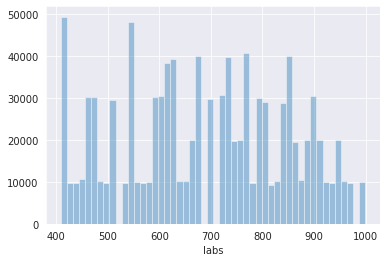

In [25]:
sns.distplot(acc_df['labs'], kde=False)
plt.show()

In [26]:
len(acc_df['labs'])

1002650

In [27]:
obj_to_in_map

{1: 409,
 2: 414,
 4: 954,
 5: 419,
 8: 790,
 9: 434,
 12: 440,
 15: 703,
 16: 671,
 19: 446,
 28: 455,
 34: 930,
 37: 462,
 38: 463,
 39: 499,
 43: 473,
 44: 470,
 47: 487,
 51: 423,
 56: 588,
 60: 550,
 66: 507,
 67: 673,
 73: 846,
 116: 533,
 78: 539,
 83: 630,
 85: 740,
 86: 968,
 89: 729,
 96: 549,
 100: 545,
 107: 567,
 80: 578,
 111: 589,
 114: 587,
 120: 560,
 124: 606,
 128: 608,
 131: 508,
 132: 618,
 133: 619,
 135: 620,
 138: 951,
 139: 623,
 142: 626,
 143: 629,
 149: 644,
 150: 647,
 151: 651,
 153: 659,
 154: 664,
 157: 504,
 160: 677,
 164: 679,
 171: 950,
 173: 695,
 175: 696,
 179: 700,
 182: 418,
 188: 720,
 190: 721,
 191: 725,
 193: 728,
 196: 923,
 199: 731,
 200: 737,
 201: 811,
 205: 742,
 210: 761,
 216: 769,
 217: 770,
 218: 772,
 219: 773,
 220: 774,
 223: 783,
 229: 792,
 231: 601,
 232: 797,
 235: 804,
 236: 806,
 237: 809,
 238: 813,
 239: 632,
 248: 732,
 250: 828,
 251: 850,
 253: 834,
 255: 837,
 256: 841,
 257: 842,
 258: 610,
 287: 851,
 267: 849,
 26